## Chapter 16 - Metric-Predicted Variable on One or Two Groups

- [16.1 - Estimating the mean and standard deviation of a normal distribution](#16.1---Estimating-the-mean-and-standard-deviation-of-a-normal-distribution)
- [16.2 - Outliers and robust estimation: the t distribution](#16.2---Outliers-and-robust-estimation:-the-t-distribution)
- [16.3 - Two Groups](#16.2---Two-Groups)


In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, t
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

### Data

In [2]:
df = pd.read_csv('data/TwoGroupIQ.csv', dtype={'Group':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
Score    120 non-null int64
Group    120 non-null category
dtypes: category(1), int64(1)
memory usage: 1.2 KB


In [3]:
df.head()

,Score,Group
0,102,Smart Drug
1,107,Smart Drug
2,92,Smart Drug
3,101,Smart Drug
4,110,Smart Drug


In [4]:
# Mean and standard deviation
df.groupby('Group').agg(['mean', 'std'])

Score           
                  mean        std
Group                            
Placebo     100.035088  17.894497
Smart Drug  107.841270  25.445201

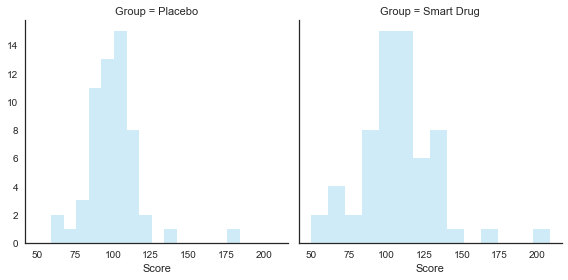

In [5]:
fg = sns.FacetGrid(df, col='Group', size=4)
fg.map(sns.distplot, 'Score', kde=False, color='#87ceeb');

In [6]:
# We are only interested in the scores of group 'Smart Drug'
y = df['Score'][df.Group == 'Smart Drug']

### 16.1 - Estimating the mean and standard deviation of a normal distribution

#### Model (Kruschke, 2015)

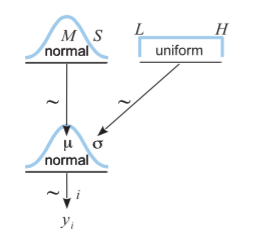

In [7]:
Image('images/fig16_2.png', width=300)

In [8]:
with pm.Model() as model:
    mu = pm.Normal('mu', y.mean(), sd=y.std())
    sigma = pm.Uniform('sigma', y.std()/1000, y.std()*1000)
    
    # PyMC's Normal likelihood can take either precision or standard deviation as an argument.
    likelihood = pm.Normal('likelihood', mu, sd=sigma, observed=y)

In [9]:
with model:
    trace = pm.sample(10000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 303.27:  11%|█▏        | 22926/200000 [00:01<00:15, 11241.56it/s]
Convergence archived at 23000
Interrupted at 23,000 [11%]: Average Loss = 357.5
100%|██████████| 12000/12000 [00:06<00:00, 1862.45it/s]


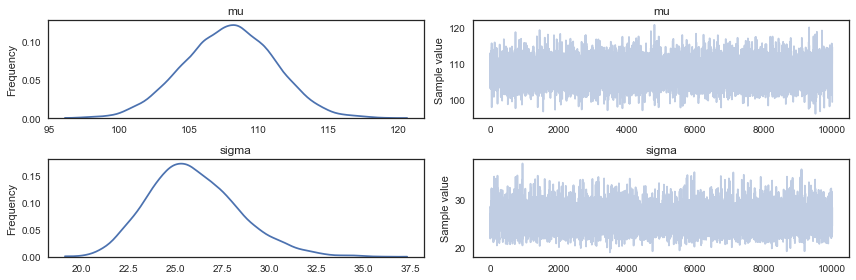

In [10]:
pm.traceplot(trace);

#### Figure 16.3

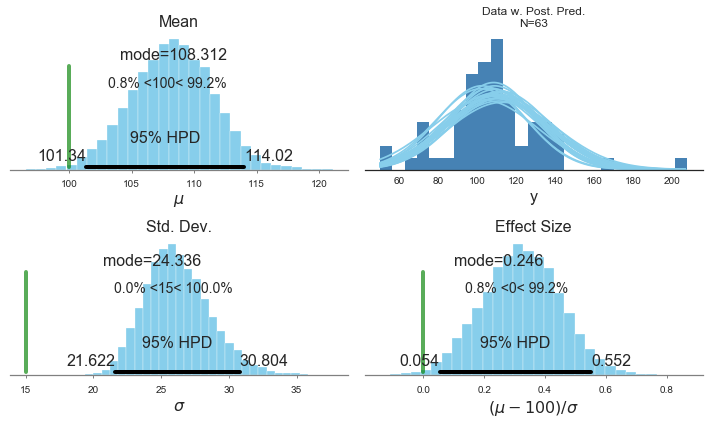

In [11]:
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2,2, figsize=(10,6))

burnin = 250

# Upper left
#plot_posterior(trace['mu'][burnin:], ax=ax1)
pm.plot_posterior(trace['mu'][burnin:], point_estimate='mode', ref_val=100, ax=ax1, color=color)
ax1.set_xlabel('$\mu$', fontdict={'size':16})
ax1.set_title('Mean', fontdict={'size':16})

# Upper right
tr_len = len(trace)
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
# 20 ranges in order to  
x_range = np.arange(y.min(), y.max())
x = np.tile(x_range.reshape(-1,1), (1,20))

ax2.hist(y, bins=25, normed=True, color='steelblue')
ax2.plot(x, norm.pdf(x, trace['mu'][stepIdxVec], trace['sigma'][stepIdxVec]), c=color)
ax2.set_xlabel('y', fontdict={'size':16})
ax2.set_title('Data w. Post. Pred.\nN=63')
[ax2.spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
ax2.yaxis.set_visible(False)

# Lower left
pm.plot_posterior(trace['sigma'][burnin:], point_estimate='mode', ref_val=15, ax=ax3, color=color)
ax3.set_xlabel('$\sigma$', fontdict={'size':16})
ax3.set_title('Std. Dev.', fontdict={'size':16})

#Lower right
pm.plot_posterior((trace['mu'][burnin:]-100)/trace['sigma'][burnin:], point_estimate='mode', ref_val=0,
                  ax=ax4, color=color)
ax4.set_title('Effect Size', fontdict={'size':16})
ax4.set_xlabel('$(\mu - 100)/\sigma$', fontdict={'size':16})

plt.tight_layout();

### 16.2 - Outliers and robust estimation: the t distribution

#### Model

In [12]:
with pm.Model() as model2:
    mu = pm.Normal('mu', y.mean(), sd=y.std())
    sigma = pm.Uniform('sigma', y.std()/1000, y.std()*1000)
    nu = pm.Exponential('nu', 1/30)
        
    likelihood = pm.StudentT('likelihood', nu,  mu, sd=sigma, observed=y)

In [13]:
with model2:
    trace2 = pm.sample(15000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 301.1:  15%|█▍        | 29188/200000 [00:03<00:17, 9646.08it/s] 
Convergence archived at 30000
Interrupted at 30,000 [15%]: Average Loss = 341.68
100%|██████████| 18000/18000 [00:18<00:00, 958.55it/s] 


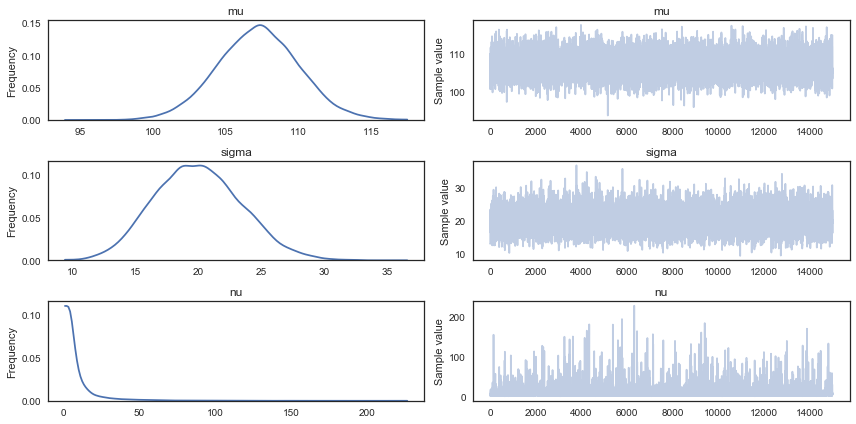

In [14]:
pm.traceplot(trace2);

#### Figure 16.9

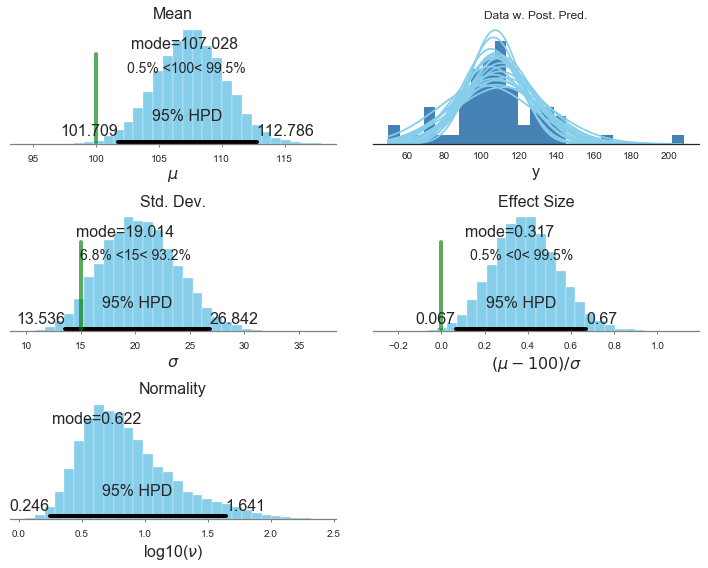

In [15]:
burnin = 250

fig, [(ax1, ax2), (ax3, ax4), (ax5, ax6)] = plt.subplots(3,2, figsize=(10,8))

# Upper left
#plot_posterior(trace['mu'][burnin:], ax=ax1)
pm.plot_posterior(trace2['mu'][burnin:], point_estimate='mode', ref_val=100, ax=ax1, color=color)
ax1.set_xlabel('$\mu$', fontdict={'size':16})
ax1.set_title('Mean', fontdict={'size':16})

# Upper right
tr_len = len(trace)
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
# 20 ranges in order to  
x_range = np.arange(y.min(), y.max())
x = np.tile(x_range.reshape(-1,1), (1,20))

ax2.hist(y, bins=25, normed=True, color='steelblue')
ax2.plot(x, norm.pdf(x, trace2['mu'][stepIdxVec], trace2['sigma'][stepIdxVec]), c='#87ceeb')
ax2.set_xlabel('y', fontdict={'size':16})
ax2.set_title('Data w. Post. Pred.')
[ax2.spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
ax2.yaxis.set_visible(False)

# Middle left
pm.plot_posterior(trace2['sigma'][burnin:], point_estimate='mode', ref_val=15, ax=ax3, color=color)
ax3.set_xlabel('$\sigma$', fontdict={'size':16})
ax3.set_title('Std. Dev.', fontdict={'size':16})

# Middle right
pm.plot_posterior((trace2['mu'][burnin:]-100)/trace2['sigma'][burnin:], point_estimate='mode', ref_val=0,
                  ax=ax4, color=color)
ax4.set_title('Effect Size', fontdict={'size':16})
ax4.set_xlabel('$(\mu - 100)/\sigma$', fontdict={'size':16})

# Lower left
pm.plot_posterior(np.log10(trace2['nu'])[burnin:], point_estimate='mode', ax=ax5, color=color)
ax5.set_title('Normality', fontdict={'size':16})
ax5.set_xlabel(r'log10($\nu$)', fontdict={'size':16})

plt.tight_layout();
ax6.set_visible(False)

### 16.2 - Two Groups

#### Model (Kruschke, 2015)

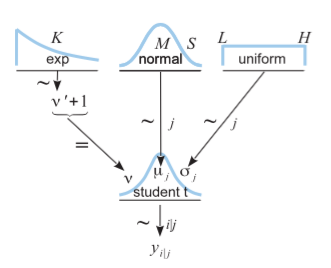

In [16]:
Image('images/fig16_11.png', width=400)

In [17]:
grp_idx = df.Group.cat.codes.as_matrix()
grp_codes = df.Group.cat.categories
n_grps = grp_codes.size

with pm.Model() as model3:
    mu = pm.Normal('mu', df.Score.mean(), sd=df.Score.std(), shape=n_grps)
    sigma = pm.Uniform('sigma', df.Score.std()/1000, df.Score.std()*1000, shape=n_grps)
    nu = pm.Exponential('nu', 1/30)
        
    likelihood = pm.StudentT('likelihood', nu,  mu[grp_idx], sd=sigma[grp_idx], observed=df.Score)

In [18]:
with model3:
    trace3 = pm.sample(15000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 548.11:  51%|█████     | 101943/200000 [00:15<00:14, 6660.52it/s]
Convergence archived at 102000
Interrupted at 102,000 [51%]: Average Loss = 572.24
100%|██████████| 18000/18000 [00:24<00:00, 744.87it/s]


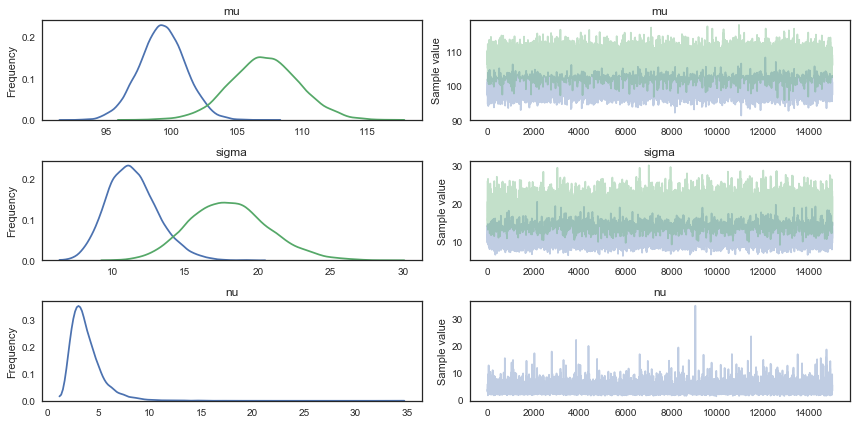

In [19]:
pm.traceplot(trace3);

#### Figure 16.12

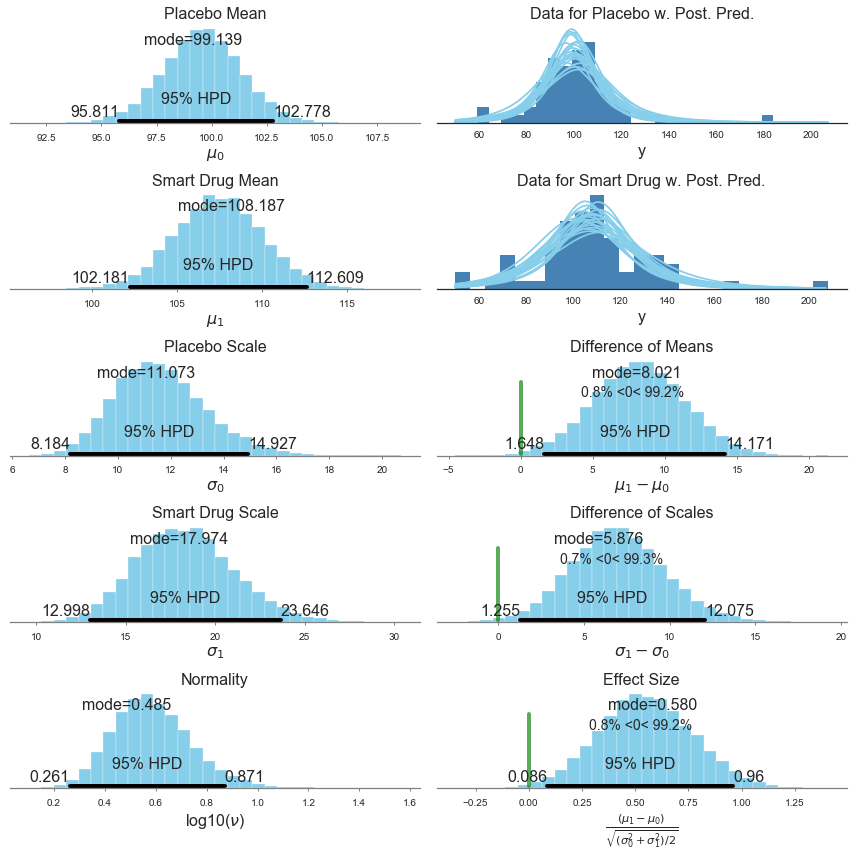

In [20]:
burnin = 250

tr3_mu0 = trace3['mu'][:,0][burnin:]
tr3_mu1 = trace3['mu'][:,1][burnin:]
tr3_sigma0 = trace3['sigma'][:,0][burnin:]
tr3_sigma1 = trace3['sigma'][:,1][burnin:]
tr3_nu = np.log10(trace3['nu'])[burnin:]

fig, axes = plt.subplots(5,2, figsize=(12, 12))

pm.plot_posterior(tr3_mu0, point_estimate='mode', ax=axes[0,0], color=color)
axes[0,0].set_xlabel('$\mu_0$', fontdict={'size':16})
axes[0,0].set_title('Placebo Mean', fontdict={'size':16})

pm.plot_posterior(tr3_mu1, point_estimate='mode', ax=axes[1,0], color=color)
axes[1,0].set_xlabel('$\mu_1$', fontdict={'size':16})
axes[1,0].set_title('Smart Drug Mean', fontdict={'size':16})

pm.plot_posterior(tr3_sigma0, point_estimate='mode', ax=axes[2,0], color=color)
axes[2,0].set_xlabel('$\sigma_0$', fontdict={'size':16})
axes[2,0].set_title('Placebo Scale', fontdict={'size':16})

pm.plot_posterior(tr3_sigma1, point_estimate='mode', ax=axes[3,0], color=color)
axes[3,0].set_xlabel('$\sigma_1$', fontdict={'size':16})
axes[3,0].set_title('Smart Drug Scale', fontdict={'size':16})

pm.plot_posterior(tr3_nu, point_estimate='mode', ax=axes[4,0], color=color)
axes[4,0].set_xlabel(r'log10($\nu$)', fontdict={'size':16})
axes[4,0].set_title('Normality', fontdict={'size':16})

tr_len = len(trace3)
n_curves = 20
stepIdxVec = np.arange(0, tr_len, tr_len//n_curves)
x_range = np.arange(df.Score.min(), df.Score.max())
x = np.tile(x_range.reshape(-1,1), (1,20))
axes[0,1].hist(df.Score[df.Group == 'Placebo'], bins=25, normed=True, color='steelblue')
axes[0,1].plot(x, t.pdf(x, loc=tr3_mu0[stepIdxVec], scale=tr3_sigma0[stepIdxVec],
                        df=trace3['nu'][stepIdxVec]), c='#87ceeb')
axes[0,1].set_xlabel('y', fontdict={'size':16})
[axes[0,1].spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
axes[0,1].yaxis.set_visible(False)
axes[0,1].set_title('Data for Placebo w. Post. Pred.', fontdict={'size':16})

axes[1,1].hist(df.Score[df.Group == 'Smart Drug'], bins=25, normed=True, color='steelblue')
axes[1,1].plot(x, t.pdf(x, loc=tr3_mu1[stepIdxVec], scale=tr3_sigma1[stepIdxVec],
                        df=trace3['nu'][stepIdxVec]), c='#87ceeb')
axes[1,1].set_xlabel('y', fontdict={'size':16})
[axes[1,1].spines[spine].set_visible(False) for spine in ['left', 'right', 'top']]
axes[1,1].yaxis.set_visible(False)
axes[1,1].set_title('Data for Smart Drug w. Post. Pred.', fontdict={'size':16})

pm.plot_posterior((tr3_mu1-tr3_mu0), point_estimate='mode', ref_val=0, ax=axes[2,1], color=color)
axes[2,1].set_xlabel('$\mu_1 - \mu_0$', fontdict={'size':16})
axes[2,1].set_title('Difference of Means', fontdict={'size':16})

pm.plot_posterior((tr3_sigma1-tr3_sigma0), point_estimate='mode', ref_val=0, ax=axes[3,1], color=color)
axes[3,1].set_xlabel('$\sigma_1 - \sigma_0$', fontdict={'size':16})
axes[3,1].set_title('Difference of Scales', fontdict={'size':16})

pm.plot_posterior((tr3_mu1-tr3_mu0)/np.sqrt((tr3_sigma0**2+tr3_sigma1**2)/2), point_estimate='mode',
                  ref_val=0, ax=axes[4,1], color=color)
axes[4,1].set_xlabel(r'$\frac{(\mu_1-\mu_0)}{\sqrt{(\sigma_0^2+\sigma_1^2)/2}}$', fontdict={'size':16})
axes[4,1].set_title('Effect Size', fontdict={'size':16})

plt.tight_layout();